# Aula 12 - Redes neurais avançadas

Neste notebook iremos utilizar a biblioteca [Keras](https://www.keras.io) para construir redes neurais do tipo Convolutional Neural Networks (CNNs) e Recurrent Neural Networks (RNNs).

## Parte 1 - Convolutional Neural Networks (CNNs)

Neste exemplo, iremos criar uma CNN para classificar imagens do dataset CIFAR-10. As imagens deste dataset são classificadas em 10 categorias.

Para começar, precisamos importar algumas bibliotecas.

In [7]:
import keras
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.utils.np_utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Para utilizar o dataset em questão, basta executar o comando abaixo.  Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída).

In [2]:
# carrega os conjuntos de treino e teste
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


Podemos visualizar alguns exemplos (entrada e saída) do dataset utilizando o código abaixo.

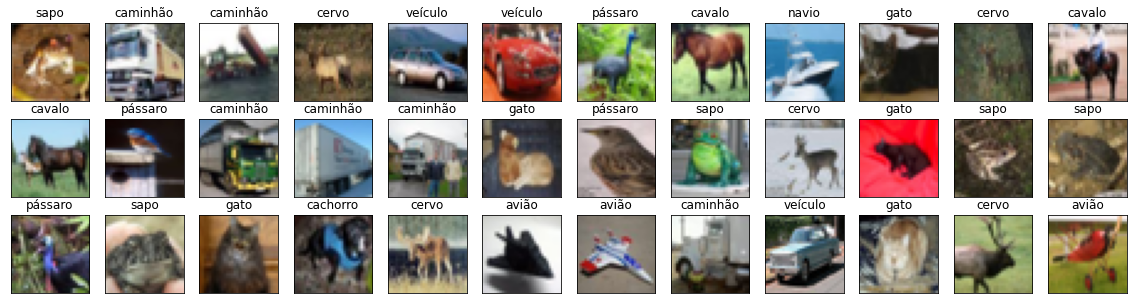

In [3]:
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

fig = plt.figure(figsize=(20, 5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(cifar10_labels[y_train[i][0]]))

Após carregar os dados, devemos tratá-los para melhorar o treinamento. No nosso caso, vamos apenas normalizar as cores (atualmente no intervalo [0,255]) para o intervalo [0,1].

In [4]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

Em seguida, podemos codificar as classes utilizando o one-hot encoding. Isto vai facilitar a tarefa de aprendizado.

In [9]:
# codificação one-hot das categorias
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

Outro passo importante é separar uma parte do conjunto de treino para validação. O objetivo é reduzir o bias do conjunto de teste.

In [ ]:
# divide os dados em treino, teste e validação
(x_train, x_valid) = x_train[5000:], x_train[:5000]
(y_train, y_valid) = y_train[5000:], y_train[:5000]

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [ ]:
# imprime o formato dos dados de entrada
print('formato dos dados de entrada:', x_train.shape)

# imprime o tamanho dos conjuntos
print(x_train.shape[0], 'amostras de treino')
print(x_test.shape[0], 'amostras de teste')
print(x_valid.shape[0], 'amostras de validação')

formato dos dados de entrada: (45000, 32, 32, 3)
45000 amostras de treino
10000 amostras de teste
5000 amostras de validação


Processados os dados, agora devemos criar a CNN. Como de costume, trabalharemos com um modelo sequencial.

In [10]:
model = Sequential()

Em seguida, podemos empilhar as camadas de convolução e agrupamento desejadas. Note que, ao final, incluímos uma algumas camadas densas (tal qual uma MLP). Note também que estamos utilizando Dropout para reduzir o overfitting.

In [11]:
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10, activation='softmax'))

Nossa rede resultante é resumida abaixo.

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        208       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

O próximo passo é compilar nosso modelo. Os parâmetros abaixo foram escolhidos por serem próprios para classificação.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Agora podemos finalmente treinar nosso modelo. **Cuidado, este processo pode demorar bastante!** 

Note que antes do treino, criamos um checkpoint. Um checkpoint permite que o modelo seja salvo em um arquivo. No nosso caso, apenas o melhor modelo será salvo. Desta forma, poderemos carregar nosso modelo posteriormente sem precisar treinar novamente a rede.

In [ ]:
# cria um checkpoint para salvar os pesos do melhor modelo encontrado no trainamento
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, save_best_only=True)

# treina o modelo
hist = model.fit(x_train, y_train, batch_size=32, epochs=100,
          validation_data=(x_valid, y_valid), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
 - 12s - loss: 1.5970 - accuracy: 0.4229 - val_loss: 1.3410 - val_accuracy: 0.5094

Epoch 00001: val_loss improved from inf to 1.34101, saving model to model.weights.best.hdf5
Epoch 2/100
 - 6s - loss: 1.2905 - accuracy: 0.5398 - val_loss: 1.2592 - val_accuracy: 0.5580

Epoch 00002: val_loss improved from 1.34101 to 1.25918, saving model to model.weights.best.hdf5
Epoch 3/100
 - 6s - loss: 1.1783 - accuracy: 0.5814 - val_loss: 1.1750 - val_accuracy: 0.5892

Epoch 00003: val_loss improved from 1.25918 to 1.17498, saving model to model.weights.best.hdf5
Epoch 4/100
 - 6s - loss: 1.1043 - accuracy: 0.6129 - val_loss: 1.1707 - val_accuracy: 0.5888

Epoch 00004: val_loss improved from 1.17498 to 1.17072, saving model to model.weights.best.hdf5
Epoch 5/100
 - 6s - loss: 1.0578 - accuracy: 0.6318 - val_loss: 1.1896 - val_accuracy: 0.5792

Epoch 00005: val_loss did not improve from 1.17072
Epoch 6/100
 - 6s - loss: 1.0261 - accuracy:

Treinado o modelo, podemos analisar seu desempenho através dos gráficos abaixo.

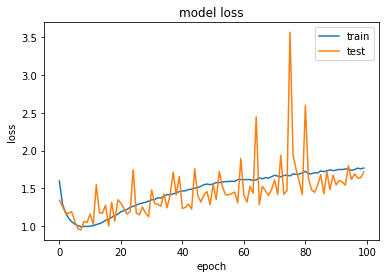

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

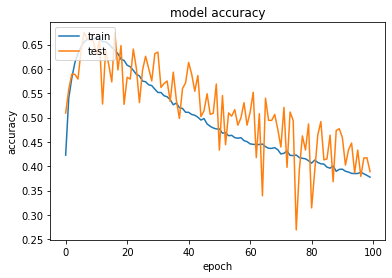

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Após concluir o treino, podemos carregar o melhor modelo utilizando o comando abaixo.

In [ ]:
# carrega os pesos do melhor modelo encontrado no treinamento
model.load_weights('model.weights.best.hdf5')

A acurácia pode ser medida como segue.

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Acurácia:', score[1])


 Acurácia: 0.6521000266075134


Finalmente, podemos visualizar algumas predições do nosso modelo para entender melhor seu comportamento.

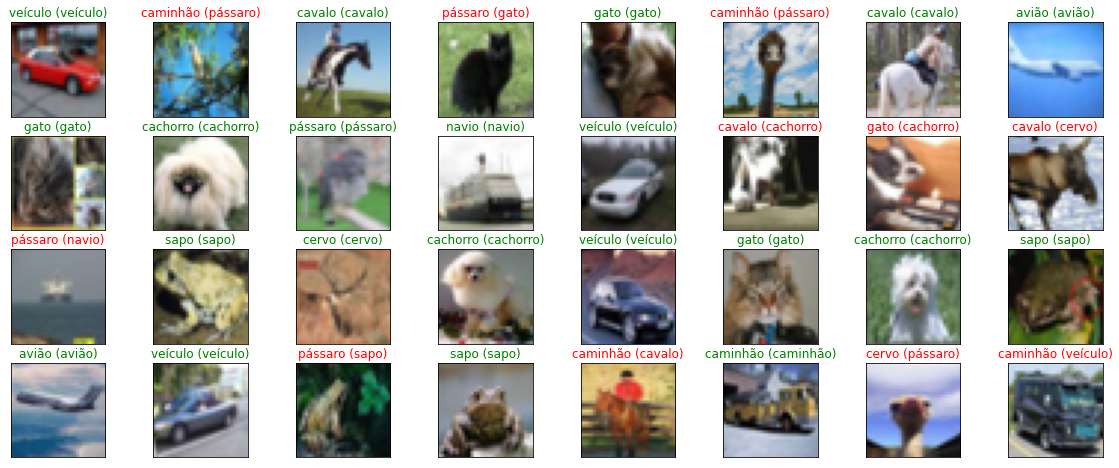

In [ ]:
# obtém as predições
y_hat = model.predict(x_test)

# define os labels (fonte: https://www.cs.toronto.edu/~kriz/cifar.html)
cifar10_labels = ['avião', 'veículo', 'pássaro', 'gato', 'cervo', 'cachorro', 'sapo', 'cavalo', 'navio', 'caminhão']

# exibe alguns exemplos aleatórios do teste, bem como sua predição e o resultado esperado
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=32, replace=False)):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(cifar10_labels[pred_idx], cifar10_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

## Parte 2 - Recurrent Neural Networks (RNNs)

Neste exemplo, iremos criar uma RNN para fazer análise de sentimentos no dataset de resenhas do IMDB. Cada review é caracterizado por um conjunto de palavras. A saída é um sentimento positivo ou negativo. Trata-se portanto de um problema de classificação binária.

Para começar, precisamos importar algumas bibliotecas.


In [13]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Model

Para utilizar o dataset em questão, basta executar o comando abaixo. Este comando retorna duas tuplas, as quais representam os dados de treino (entrada e saída) e de teste (entrada e saída). No nosso caso estamos ainda limitando o conjunto de palavras às 5000 mais frequentes. Tal procedimento reduz a complexidade do problema.

In [14]:
# carrega o dataset mantendo apenas as 5000 palavras mais frequentes
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

17473536/17464789 [==============================] - 0s 0us/step


Podemos ver alguns exemplos dos dados como segue.

In [15]:
print(X_train[0])
print(y_train[0])

print(X_train[1])
print(y_train[1])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 2, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 2, 19, 178, 32]
1
[1, 194, 1153, 194, 2, 78, 228, 5, 6, 1463, 4369, 2, 134, 26, 4, 715, 8, 

Após os tratamentos acima, podemos identificar o formato resultante dos nossos dados com os comandos abaixo.

In [16]:
# imprime o formato dos dados de entrada
print('formato dos dados de entrada:', X_train.shape)
#print('formato dos dados de entrada (primeiro exemplo):', len(X_train[0]))

# imprime o tamanho dos conjuntos
print(X_train.shape[0], 'amostras de treino')
print(X_test.shape[0], 'amostras de teste')

formato dos dados de entrada: (25000,)
25000 amostras de treino
25000 amostras de teste


De modo a normalizar os dados, vamos limitar cada review a 500 palavras apenas.

In [17]:
# alguns processamentos adicionais para normalizar os dados
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

Agora podemos criar o modelo. Novamente, é um modelo sequencial. A diferença é que agora vamos utilizar camadas do tipo LSTM.

In [18]:
# cria o modelo
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

O resumo do modelo é apresentado abaixo.

In [19]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           160000    
                                                                 
 lstm (LSTM)                 (None, 100)               53200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


O próximo passo é treinar o modelo.

In [ ]:
hist = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 310s 12ms/step - loss: 0.3494 - accuracy: 0.8543 - val_loss: 0.3344 - val_accuracy: 0.8577
Epoch 2/3
25000/25000 [==============================] - 307s 12ms/step - loss: 0.2886 - accuracy: 0.8846 - val_loss: 0.3279 - val_accuracy: 0.8728
Epoch 3/3
25000/25000 [==============================] - 308s 12ms/step - loss: 0.2783 - accuracy: 0.8878 - val_loss: 0.3824 - val_accuracy: 0.8620


Podemos salvar o modelo aprendido como segue.

In [ ]:
model.save('rnn.weights.h5')

Treinado o modelo, podemos visualizar seu desempenho com os gráficos abaixo.

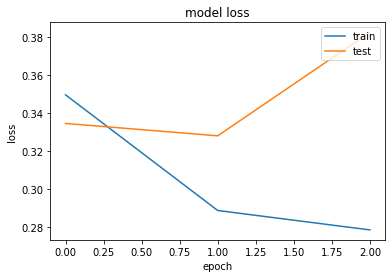

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

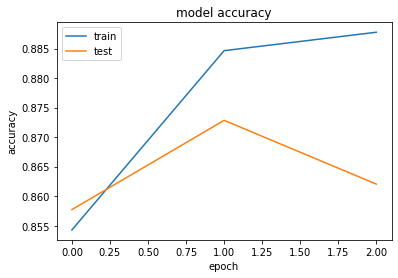

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

O modelo aprendido pode ser carregado como segue.

In [ ]:
model.load_weights('rnn.weights.h5')

Finalmente, podemos avaliar a acurácia do modelo.

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Acurácia: %.2f%%" % (scores[1]*100))

Acurácia: 86.20%


## Exercícios

### Exercício 1

Ajuste a rede CNN vista acima para obter uma acurácia melhor no dataset CIFAR-10. Sua tarefa consiste em modificar a arquitetura da rede (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.).

In [ ]:
# your answer here

### Exercício 2

Ajuste a rede RNN vista acima para obter uma acurácia melhor no dataset IMDB. Sua tarefa consiste em modificar a arquitetura da rede (e.g., quantidade de camadas, ordem das camadas, tamanho das camadas, loss function, otimizador, número de épocas, etc.).

In [ ]:
# your answer here